In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re

from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

import nltk

pd.set_option('display.max_colwidth', None)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import EarlyStopping

In [2]:
#Extract reddit data
reddit_data = pd.read_csv('../input/twitter-and-reddit-sentimental-analysis-dataset/Reddit_Data.csv')
reddit_data.rename(columns = {'clean_comment': 'text'}, inplace = True)

In [3]:
reddit_data.head()

,text,category
0,family mormon have never tried explain them they still stare puzzled from time time like some kind strange creature nonetheless they have come admire for the patience calmness equanimity acceptance and compassion have developed all the things buddhism teaches,1
1,buddhism has very much lot compatible with christianity especially considering that sin and suffering are almost the same thing suffering caused wanting things shouldn want going about getting things the wrong way christian this would mean wanting things that don coincide with god will and wanting things that coincide but without the aid jesus buddhism could also seen proof god all mighty will and omnipotence certainly christians are lucky have one such christ there side but what about everyone else well many christians believe god grace salvation and buddhism god way showing grace upon others would also help study the things jesus said and see how buddha has made similar claims such rich man getting into heaven joke basically advocating that should rid ourselves material possessions fact distinctly remembered jesus making someone cry because that someone asked what achieve salvation and jesus replied with live like buddhist very very roughly translated also point out that buddha rarely spoke anything about god theory personally because knew well enough leave that jesus and mohamed who came later just remember conflict difference opinion but education can fun involving and enlightening easier teach something than prove right like intelligent design,1
2,seriously don say thing first all they won get its too complex explain normal people anyway and they are dogmatic then doesn matter what you say see mechante post and for any reason you decide later life move from buddhism and that doesn suit you identity though you still get keep all the wisdom then your family will treat you like you went through weird hippy phase for while there didncha and you never hear the end pro tip don put one these your wall jpg,-1
3,what you have learned yours and only yours what you want teach different focus the goal not the wrapping paper buddhism can passed others without word about the buddha,0
4,for your own benefit you may want read living buddha living christ thich nhat hanh you might find any subsequent discussions with your loved ones easier you are able articulate some the parallels that exist between buddhism and christianity don surprised they react negatively for having lost you treat them with compassion and deserved understanding although they may indeed display signs being hurt your new path properly sharing with them way that may alleviate their fear something they may perceive wrong the very least alien their beliefs may help allowing them the long run accept although not necessarily agree with your decision regardless where they end you have make your own way,1


In [4]:
#Extract twitter data
twitter_data = pd.read_csv('../input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv')
twitter_data.rename(columns = {'clean_text': 'text'}, inplace = True)

In [5]:
twitter_data.head()

,text,category
0,when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples,-1.0
1,talk all the nonsense and continue all the drama will vote for modi,0.0
2,what did just say vote for modi welcome bjp told you rahul the main campaigner for modi think modi should just relax,1.0
3,asking his supporters prefix chowkidar their names modi did great service now there confusion what read what not now crustal clear what will crass filthy nonsensical see how most abuses are coming from chowkidars,1.0
4,answer who among these the most powerful world leader today trump putin modi may,1.0


> We can observe that the two dataframes have the same columns, so we can concate them

In [6]:
#Combine both dataframes into one master dataframe
data = pd.concat([reddit_data, twitter_data], ignore_index = True)

In [7]:
data.head()

,text,category
0,family mormon have never tried explain them they still stare puzzled from time time like some kind strange creature nonetheless they have come admire for the patience calmness equanimity acceptance and compassion have developed all the things buddhism teaches,1.0
1,buddhism has very much lot compatible with christianity especially considering that sin and suffering are almost the same thing suffering caused wanting things shouldn want going about getting things the wrong way christian this would mean wanting things that don coincide with god will and wanting things that coincide but without the aid jesus buddhism could also seen proof god all mighty will and omnipotence certainly christians are lucky have one such christ there side but what about everyone else well many christians believe god grace salvation and buddhism god way showing grace upon others would also help study the things jesus said and see how buddha has made similar claims such rich man getting into heaven joke basically advocating that should rid ourselves material possessions fact distinctly remembered jesus making someone cry because that someone asked what achieve salvation and jesus replied with live like buddhist very very roughly translated also point out that buddha rarely spoke anything about god theory personally because knew well enough leave that jesus and mohamed who came later just remember conflict difference opinion but education can fun involving and enlightening easier teach something than prove right like intelligent design,1.0
2,seriously don say thing first all they won get its too complex explain normal people anyway and they are dogmatic then doesn matter what you say see mechante post and for any reason you decide later life move from buddhism and that doesn suit you identity though you still get keep all the wisdom then your family will treat you like you went through weird hippy phase for while there didncha and you never hear the end pro tip don put one these your wall jpg,-1.0
3,what you have learned yours and only yours what you want teach different focus the goal not the wrapping paper buddhism can passed others without word about the buddha,0.0
4,for your own benefit you may want read living buddha living christ thich nhat hanh you might find any subsequent discussions with your loved ones easier you are able articulate some the parallels that exist between buddhism and christianity don surprised they react negatively for having lost you treat them with compassion and deserved understanding although they may indeed display signs being hurt your new path properly sharing with them way that may alleviate their fear something they may perceive wrong the very least alien their beliefs may help allowing them the long run accept although not necessarily agree with your decision regardless where they end you have make your own way,1.0


In [8]:
print(f'Shape : {data.shape}')

Shape : (200229, 2)


In [9]:
#Check for any null values
data.isna().sum()

text        104
category      7
dtype: int64

In [10]:
#Drop rows with null values
data.dropna(axis = 0, inplace = True)

In [11]:
#Checking the shape of the data to ensure nothing is broken
data.shape

(200118, 2)

In [12]:
#Getting Stopwords
from spacy.lang.en.stop_words import STOP_WORDS
stopwords = list(STOP_WORDS)

#Getting a list of punctuations
from string import punctuation
punct = list(punctuation)

print(f"Length of punctuations:\t {len(punct)} \nLength of stopwords:\t {len(stopwords)}")

Length of punctuations:	 32 
Length of stopwords:	 326


In [13]:
print(f'Samples from stop words : {np.random.choice(stopwords, 15)}', end='\n\n')
print(f'Samples from punctuation : {np.random.choice(punct, 15)}')

Samples from stop words : ['why' 'which' 'anyway' 'back' 'after' 'give' 'upon' 'yourself' 'itself'
 'unless' 'thus' 'please' 'an' 'although' 'really']

Samples from punctuation : ['\\' '!' '|' '#' '-' '/' ',' '&' ';' '}' ')' ')' '}' '?' '|']


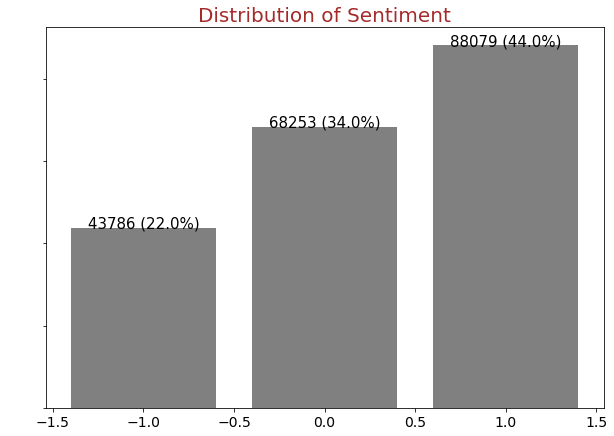

In [14]:
plt.figure(figsize = (10,7))
categories = list(data['category'].value_counts().index)
values = list(data['category'].value_counts().values)
percentages = [round(i,0) for i in data['category'].value_counts(normalize=True).values*100]

ax = plt.bar(categories, values, color='gray')

for cat, val, percent in zip(categories, values, percentages):
    plt.text(cat, val, f'{val} ({percent}%)', fontsize=15, ha='center')
    
plt.xticks(rotation = 0, size = 14)
plt.yticks(color = 'white')
plt.title('Distribution of Sentiment', size = 20, color='brown');

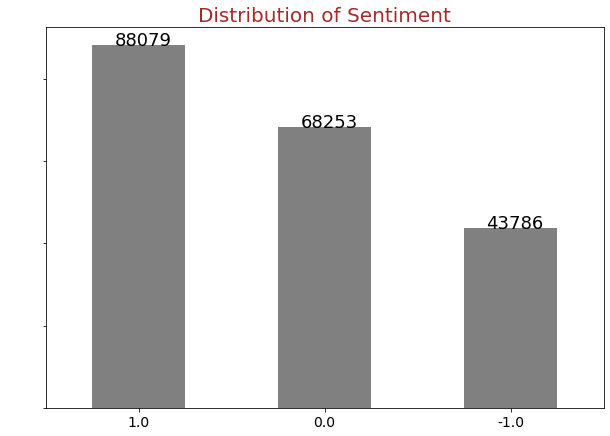

In [15]:
fig , ax = plt.subplots(figsize = (10,7))
ax = data['category'].value_counts().plot(kind = 'bar', color='gray')

plt.xticks(rotation = 0, size = 14)
plt.yticks(color = 'white')
plt.title('Distribution of Sentiment', size = 20, color='brown')

ax.annotate(text = data['category'].value_counts().values[0], xy = (-0.13,88079), size = 18)
ax.annotate(text = data['category'].value_counts().values[1], xy = (0.87,68253), size = 18)
ax.annotate(text = data['category'].value_counts().values[2], xy = (1.87,43786), size = 18)

plt.show()

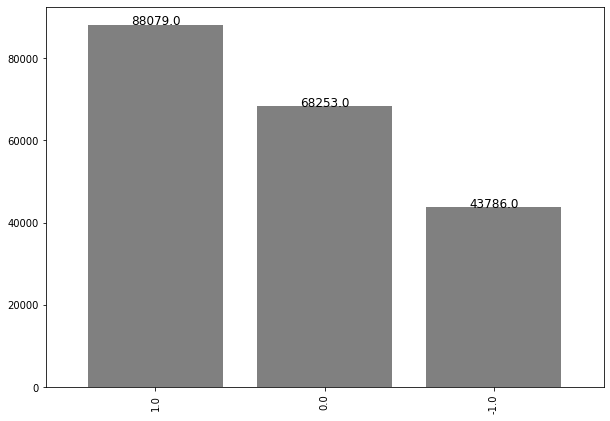

In [16]:
plt.figure(figsize = (10,7))
s = data['category'].value_counts()
ax = s.plot.bar(width=.8, color='gray') 

for i, v in s.reset_index().iterrows():
    ax.text(i, v.category, v.category, fontsize=12, ha='center')

In [17]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Create a Vectorizer Object using default parameters
hash_vectorizer = HashingVectorizer()

# Convert a collection of text documents to a matrix of token counts
token_count_matrix=hash_vectorizer.fit_transform(data['text'])

print(f'The size of the count matrix for the texts = {token_count_matrix.get_shape()}')
print(f'The sparse count matrix is as follows:')
print(token_count_matrix)

The size of the count matrix for the texts = (200118, 1048576)
The sparse count matrix is as follows:
  (0, 66497)	0.14002800840280097
  (0, 88541)	0.28005601680560194
  (0, 99311)	0.14002800840280097
  (0, 158803)	-0.28005601680560194
  (0, 176558)	0.14002800840280097
  (0, 180525)	-0.14002800840280097
  (0, 189643)	-0.14002800840280097
  (0, 216640)	-0.14002800840280097
  (0, 246361)	-0.14002800840280097
  (0, 281416)	-0.14002800840280097
  (0, 286878)	-0.28005601680560194
  (0, 298956)	0.14002800840280097
  (0, 331884)	-0.14002800840280097
  (0, 336791)	0.14002800840280097
  (0, 570460)	-0.14002800840280097
  (0, 590295)	-0.14002800840280097
  (0, 636025)	0.14002800840280097
  (0, 639622)	-0.14002800840280097
  (0, 647008)	-0.14002800840280097
  (0, 694840)	0.14002800840280097
  (0, 699224)	-0.14002800840280097
  (0, 720710)	0.14002800840280097
  (0, 770962)	-0.14002800840280097
  (0, 777676)	0.14002800840280097
  (0, 873637)	-0.14002800840280097
  :	:
  (200117, 257965)	0.162221421

In [18]:
# Create a tf_idf object using default parameters
tf_idf_transformer=TfidfTransformer(use_idf=True, smooth_idf=True, sublinear_tf=False) 

# Fit to the count matrix, then transform it to a normalized tf-idf representation
tf_idf_matrix = tf_idf_transformer.fit_transform(token_count_matrix)

print(f'The size of the tf_idf matrix for the texts = {tf_idf_matrix.get_shape()}')
print(f'The sparse tf_idf matrix is as follows:')
print(tf_idf_matrix)

The size of the tf_idf matrix for the texts = (200118, 1048576)
The sparse tf_idf matrix is as follows:
  (0, 1005723)	-0.10434674855047239
  (0, 994433)	0.20921265097415948
  (0, 975831)	-0.07876591237300015
  (0, 949757)	0.10741568289205695
  (0, 930443)	0.07293586296657113
  (0, 927512)	0.24593257824400871
  (0, 905713)	0.11809068666970735
  (0, 901236)	-0.105672412539855
  (0, 899007)	-0.2120840759393819
  (0, 873637)	-0.1901092345355487
  (0, 777676)	0.09861197660578791
  (0, 770962)	-0.24888387265290973
  (0, 720710)	0.18517734322196264
  (0, 699224)	-0.1519147722870182
  (0, 694840)	0.11603906817052086
  (0, 647008)	-0.19963034553967557
  (0, 639622)	-0.20067472298622857
  (0, 636025)	0.1322760125534672
  (0, 590295)	-0.09491272896800283
  (0, 570460)	-0.14735501522285915
  (0, 336791)	0.19736979100171234
  (0, 331884)	-0.07464372128638792
  (0, 298956)	0.2159945766799911
  (0, 286878)	-0.08436432457367855
  (0, 281416)	-0.27657228563153397
  :	:
  (200117, 800174)	-0.2609060288

In [19]:
#Getting X and y

X = tf_idf_matrix
y = data.category

#Splitting the data into training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [20]:
#Creating, fitting and scoring classifier
classifier = LinearSVC()
classifier.fit(X_train, y_train)

print(f"Train Accuracy: {classifier.score(X_train, y_train) * 100:.3f}%", )
print(f"Test Accuracy: {classifier.score(X_test, y_test) * 100:.3f}%", )

Train Accuracy: 97.941%
Test Accuracy: 94.388%


I will delete stop words and apply some preprocessing to reduce vocabulary and see the accuracy

In [21]:
data.head()

,text,category
0,family mormon have never tried explain them they still stare puzzled from time time like some kind strange creature nonetheless they have come admire for the patience calmness equanimity acceptance and compassion have developed all the things buddhism teaches,1.0
1,buddhism has very much lot compatible with christianity especially considering that sin and suffering are almost the same thing suffering caused wanting things shouldn want going about getting things the wrong way christian this would mean wanting things that don coincide with god will and wanting things that coincide but without the aid jesus buddhism could also seen proof god all mighty will and omnipotence certainly christians are lucky have one such christ there side but what about everyone else well many christians believe god grace salvation and buddhism god way showing grace upon others would also help study the things jesus said and see how buddha has made similar claims such rich man getting into heaven joke basically advocating that should rid ourselves material possessions fact distinctly remembered jesus making someone cry because that someone asked what achieve salvation and jesus replied with live like buddhist very very roughly translated also point out that buddha rarely spoke anything about god theory personally because knew well enough leave that jesus and mohamed who came later just remember conflict difference opinion but education can fun involving and enlightening easier teach something than prove right like intelligent design,1.0
2,seriously don say thing first all they won get its too complex explain normal people anyway and they are dogmatic then doesn matter what you say see mechante post and for any reason you decide later life move from buddhism and that doesn suit you identity though you still get keep all the wisdom then your family will treat you like you went through weird hippy phase for while there didncha and you never hear the end pro tip don put one these your wall jpg,-1.0
3,what you have learned yours and only yours what you want teach different focus the goal not the wrapping paper buddhism can passed others without word about the buddha,0.0
4,for your own benefit you may want read living buddha living christ thich nhat hanh you might find any subsequent discussions with your loved ones easier you are able articulate some the parallels that exist between buddhism and christianity don surprised they react negatively for having lost you treat them with compassion and deserved understanding although they may indeed display signs being hurt your new path properly sharing with them way that may alleviate their fear something they may perceive wrong the very least alien their beliefs may help allowing them the long run accept although not necessarily agree with your decision regardless where they end you have make your own way,1.0


In [22]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [23]:
lemm = nltk.WordNetLemmatizer()
stem = nltk.PorterStemmer()

In [24]:
def clean_txt(row_value):
    row_value = re.sub('[^\w\s]', '', row_value)
    words = row_value.lower().split()
    words = [word for word in words if word not in STOP_WORDS]
    words = [lemm.lemmatize(word) for word in words]
    return ' '.join(words)

In [25]:
data['clean_txt'] = data['text'].apply(clean_txt)

In [26]:
data.head(2)

,text,category,clean_txt
0,family mormon have never tried explain them they still stare puzzled from time time like some kind strange creature nonetheless they have come admire for the patience calmness equanimity acceptance and compassion have developed all the things buddhism teaches,1.0,family mormon tried explain stare puzzled time time like kind strange creature nonetheless come admire patience calmness equanimity acceptance compassion developed thing buddhism teach
1,buddhism has very much lot compatible with christianity especially considering that sin and suffering are almost the same thing suffering caused wanting things shouldn want going about getting things the wrong way christian this would mean wanting things that don coincide with god will and wanting things that coincide but without the aid jesus buddhism could also seen proof god all mighty will and omnipotence certainly christians are lucky have one such christ there side but what about everyone else well many christians believe god grace salvation and buddhism god way showing grace upon others would also help study the things jesus said and see how buddha has made similar claims such rich man getting into heaven joke basically advocating that should rid ourselves material possessions fact distinctly remembered jesus making someone cry because that someone asked what achieve salvation and jesus replied with live like buddhist very very roughly translated also point out that buddha rarely spoke anything about god theory personally because knew well enough leave that jesus and mohamed who came later just remember conflict difference opinion but education can fun involving and enlightening easier teach something than prove right like intelligent design,1.0,buddhism lot compatible christianity especially considering sin suffering thing suffering caused wanting thing shouldn want going getting thing wrong way christian mean wanting thing don coincide god wanting thing coincide aid jesus buddhism seen proof god mighty omnipotence certainly christian lucky christ christian believe god grace salvation buddhism god way showing grace help study thing jesus said buddha similar claim rich man getting heaven joke basically advocating rid material possession fact distinctly remembered jesus making cry asked achieve salvation jesus replied live like buddhist roughly translated point buddha rarely spoke god theory personally knew leave jesus mohamed came later remember conflict difference opinion education fun involving enlightening easier teach prove right like intelligent design


Tallest sentense contains 784 word


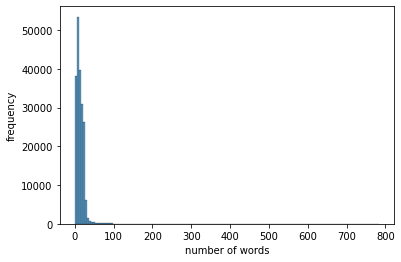

In [27]:
words_num = data['clean_txt'].apply(lambda x: len(x.split()))
sns.histplot(words_num, bins=150);
plt.xlabel('number of words')
plt.ylabel('frequency');

print(f'Tallest sentense contains {max(words_num)} word')

In [28]:
data['len'] = words_num
data.head(1)

,text,category,clean_txt,len
0,family mormon have never tried explain them they still stare puzzled from time time like some kind strange creature nonetheless they have come admire for the patience calmness equanimity acceptance and compassion have developed all the things buddhism teaches,1.0,family mormon tried explain stare puzzled time time like kind strange creature nonetheless come admire patience calmness equanimity acceptance compassion developed thing buddhism teach,24


In [29]:
display(data.groupby('category')[['len']].count())
display(data.groupby('category')[['len']].mean())
display(data.groupby('category')[['len']].median())

,len
category,
-1.0,43786
0.0,68253
1.0,88079


,len
category,
-1.0,16.453570
0.0,8.948515
1.0,16.552004


,len
category,
-1.0,15.0
0.0,7.0
1.0,14.0


> **There is no relation between number of words and its category.**

In [30]:
document = [txt.split() for txt in data.clean_txt]

In [31]:
!pip install gensim --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 41.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: gensim
    Found existing installation: gensim 4.0.1
    Uninstalling gensim-4.0.1:
      Successfully uninstalled gensim-4.0.1


In [32]:
import gensim

In [33]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=300, window=7, min_count=10, epochs=5)

In [34]:
w2v_model.build_vocab(document)

In [35]:
words = w2v_model.wv.key_to_index
vocab_size = len(words)
print(f'Vocab size : {vocab_size}')

Vocab size : 15650


In [36]:
words

{'modi': 0,
 'india': 1,
 'people': 2,
 'bjp': 3,
 'like': 4,
 'congress': 5,
 'election': 6,
 'vote': 7,
 'indian': 8,
 'time': 9,
 'narendra': 10,
 'year': 11,
 'country': 12,
 'govt': 13,
 'know': 14,
 'want': 15,
 'dont': 16,
 'party': 17,
 'good': 18,
 'government': 19,
 'nation': 20,
 'modis': 21,
 'rahul': 22,
 'think': 23,
 'power': 24,
 'need': 25,
 'minister': 26,
 'gandhi': 27,
 'come': 28,
 'said': 29,
 'leader': 30,
 'thing': 31,
 'pakistan': 32,
 'money': 33,
 'work': 34,
 'hai': 35,
 'right': 36,
 'day': 37,
 'say': 38,
 'credit': 39,
 'space': 40,
 'support': 41,
 'job': 42,
 'medium': 43,
 'new': 44,
 'win': 45,
 'prime': 46,
 'don': 47,
 'world': 48,
 'way': 49,
 'sir': 50,
 'today': 51,
 'opposition': 52,
 '2019': 53,
 'state': 54,
 'let': 55,
 'going': 56,
 'news': 57,
 'great': 58,
 'political': 59,
 'scientist': 60,
 'anti': 61,
 'chowkidar': 62,
 'poor': 63,
 'best': 64,
 'hindu': 65,
 '2014': 66,
 'better': 67,
 'family': 68,
 'muslim': 69,
 'question': 70,
 'ma

In [37]:
w2v_model.train(document, total_examples=len(document), epochs=10)

(23597648, 27890830)

In [38]:
w2v_model.wv.most_similar('time')

[('period', 0.3425219655036926),
 ('twice', 0.3033468425273895),
 ('phase', 0.3019913136959076),
 ('minute', 0.3000034689903259),
 ('precious', 0.2969435751438141),
 ('week', 0.29644182324409485),
 ('5yrs', 0.28853052854537964),
 ('short', 0.2872864007949829),
 ('hour', 0.28446120023727417),
 ('overdue', 0.28279006481170654)]

In [39]:
w2v_model.wv['time'][:12]     #vector of the word

array([ 0.7243266 ,  0.66904867, -0.50757474, -0.67235583,  0.11304748,
       -0.86668813,  0.5299511 , -0.4463435 ,  0.00193261,  0.28217024,
        0.10147247, -0.253653  ], dtype=float32)

In [40]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['clean_txt'])

In [41]:
vocab_size = len(tokenizer.index_word)
print(f'Total words : {vocab_size}')

Total words : 125446


In [42]:
x = pad_sequences(tokenizer.texts_to_sequences(data['clean_txt']), maxlen=100)

In [43]:
x[40]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
         366, 16628,  8492, 27514, 47217,  1104,  3568,   182,  8493,
        4577,    55,   234,  7796,  3599,   182,   125, 10892,   200,
         956, 12204,   127,  1760,     5,    24,   366,   212,    32,
         291,   174,    90,  7634,  1333,   143,  1453,  2919,    24,
          68,   185,   366,    39,  6743,   258,   291,    50,   123,
        6987,  3568,  1132,   401, 47218, 47219, 10563,  9367,   435,
        3820,  4431, 11302,  8694,  1131,  2803,   174,  3295,  1947,
         291,  1559,  1142,  1132,   401,   134,   188,    55,   234,
         418,   134,   188,   122,   143,  3599, 15654,  2175,  3570,
         366], dtype=int32)

In [46]:
embedding_matrix = np.zeros((vocab_size, 300))
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [52]:
for word, ind in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
    

In [55]:
embedding_matrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05230372, 0.24022184, 0.11907454, ..., 0.12979288, 0.09521169,
        0.06891564],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [61]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=300, weights=[embedding_matrix], input_length=40, trainable=False)

In [84]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 300)           37633800  
_________________________________________________________________
dropout_4 (Dropout)          (None, 40, 300)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 37,794,301
Trainable params: 160,501
Non-trainable params: 37,633,800
_________________________________________________________________


In [85]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [86]:
callbacks = EarlyStopping(monitor='val_acc', patience=4)

In [ ]:
history = model.fit(x, data['category'],
                    batch_size=1024,
                    epochs=10,
                    validation_split=0.1,
                    callbacks=[callbacks],
                   steps_per_epoch=100)

Epoch 1/10
100/100 [==============================] - 54s 542ms/step - loss: nan - accuracy: 0.3401 - val_loss: nan - val_accuracy: 0.3394
Epoch 2/10
100/100 [==============================] - 53s 533ms/step - loss: nan - accuracy: 0.3426 - val_loss: nan - val_accuracy: 0.3394
Epoch 3/10
100/100 [==============================] - 54s 537ms/step - loss: nan - accuracy: 0.3404 - val_loss: nan - val_accuracy: 0.3394
Epoch 4/10
100/100 [==============================] - 53s 533ms/step - loss: nan - accuracy: 0.3416 - val_loss: nan - val_accuracy: 0.3394
Epoch 5/10
100/100 [==============================] - 53s 526ms/step - loss: nan - accuracy: 0.3414 - val_loss: nan - val_accuracy: 0.3394
Epoch 6/10
100/100 [==============================] - 53s 531ms/step - loss: nan - accuracy: 0.3433 - val_loss: nan - val_accuracy: 0.3394
Epoch 7/10
100/100 [==============================] - 58s 579ms/step - loss: nan - accuracy: 0.3397 - val_loss: nan - val_accuracy: 0.3394
Epoch 8/10
100/100 [=======